# Интеллектуальная система обнаружения атакующих программных кодов

Цель этого проекта - создать двоичный классификатор, способный отличать доброкачественный сетевой трафик от вредоносного на основе [CIC-IDS-2018 dataset](https://www.unb.ca/cic/datasets/ids-2018.html).  
Классификатор будет использовать подмножество функций, созданных [CICFlowMeter](https://github.com/ISCX/CICFlowMeter) для каждого кейса.  

Оценщик основан на самообучающейся сети Кохонена, поэтому важную роль в работе играет устранение корреляции между адаптированными входными данными.


БД CIC-IDS-2018 может быть найдена по ссылке (https://www.unb.ca/cic/datasets/ids-2018.html).

In [4]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}


## 1. Подготовка датасета

На первом этапе набор данных загружается в фрейм данных Pandas, добавляются дополнительные столбцы label_cat (числовая категория метки) и label_is_attack (двоичный целевой идентификатор, указывающий доброкачественный и вредоносный сетевой трафик), и фрейм данных разделяется на предсказатель. переменные `X` и целевые переменные` y`.

In [4]:
csv_files = glob.glob(os.path.join(dataset_base_path, '*.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

## 2. Разработка функций

### 2.1. Низкая дисперсия

In [5]:
stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [6]:
X = X.drop(columns=features_no_variance)

### 2.2. Нежелательные функции

Прогнозы классификатора должны быть независимыми от функций «timestamp» и «dst_port», чтобы распознавать атаки независимо от времени и порта назначения, против которого они выполняются. С этой целью обе функции удаляются из набора данных.

In [7]:
X = X.drop(columns=['timestamp', 'dst_port'])

### 2.3. Мультиколлинеарные особенности

На данном этапе удаляется шум (элементы с высокой корреляцией между собой) по методу ранговой корреляции Спирмена.

На следующих рисунках показана тепловая карта, визуализирующая корреляция между различными парами функций, и дендограмма, иллюстрирующая кластеризацию функций.

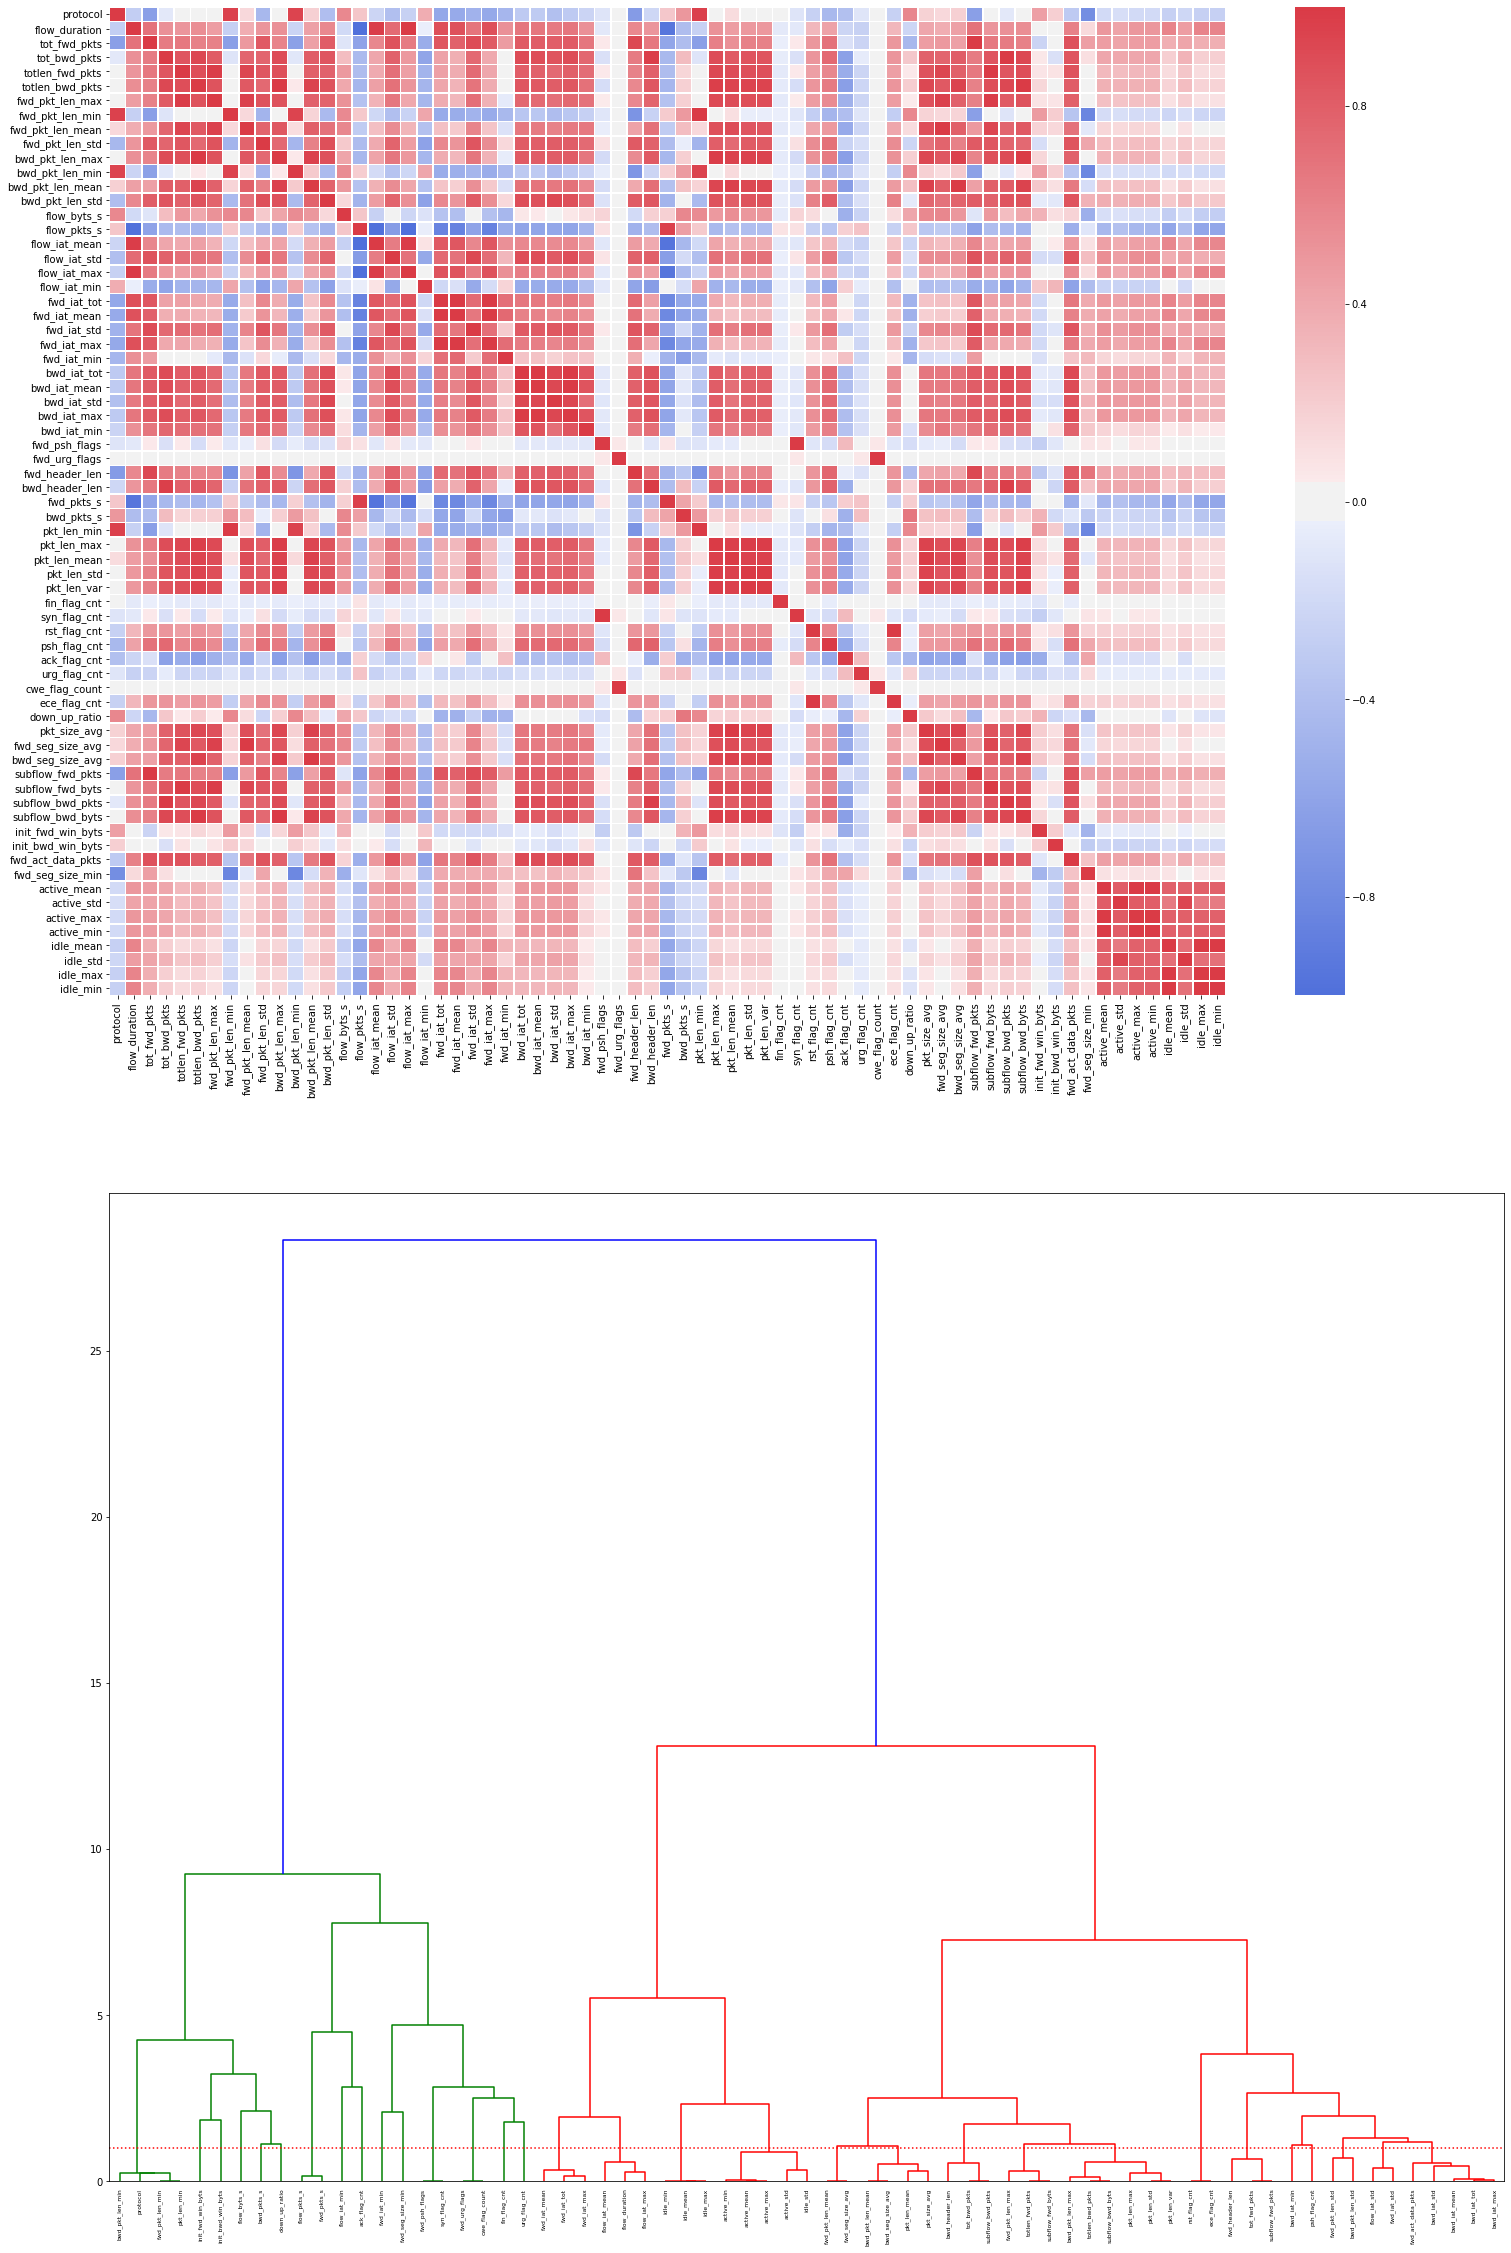

In [8]:
cluster_threshold = 1

corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 40))

sns.heatmap(corr, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True), ax=ax1)

dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax2, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax2.plot([0, 1000], [cluster_threshold, cluster_threshold], ':r')
plt.show()

Тепловая карта демонстрирует, что набор данных содержит изрядное количество функций с высокой корреляцией между собой. Чтобы удалить избыточные объекты, пороговое значение расстояния между кластерами, равное «1», используется для выбора объектов из соответствующих кластеров.

In [9]:
cluster_ids = hierarchy.fcluster(corr_linkage, cluster_threshold, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

selected_features = X.columns[selected_features].tolist()

print('Selected features:')
pd.Series(selected_features)

Selected features:


0              protocol
1         flow_duration
2          tot_fwd_pkts
3          tot_bwd_pkts
4       totlen_fwd_pkts
5       totlen_bwd_pkts
6      fwd_pkt_len_mean
7       fwd_pkt_len_std
8      bwd_pkt_len_mean
9           flow_byts_s
10          flow_pkts_s
11         flow_iat_std
12         flow_iat_min
13          fwd_iat_tot
14          fwd_iat_min
15          bwd_iat_tot
16          bwd_iat_min
17        fwd_psh_flags
18        fwd_urg_flags
19           bwd_pkts_s
20         fin_flag_cnt
21         rst_flag_cnt
22         psh_flag_cnt
23         ack_flag_cnt
24         urg_flag_cnt
25        down_up_ratio
26    init_fwd_win_byts
27    init_bwd_win_byts
28     fwd_seg_size_min
29          active_mean
30            idle_mean
dtype: object

In [6]:
X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 31


На следующем рисунке показана тепловая карта корреляции после удаления сильно коррелированных функций.

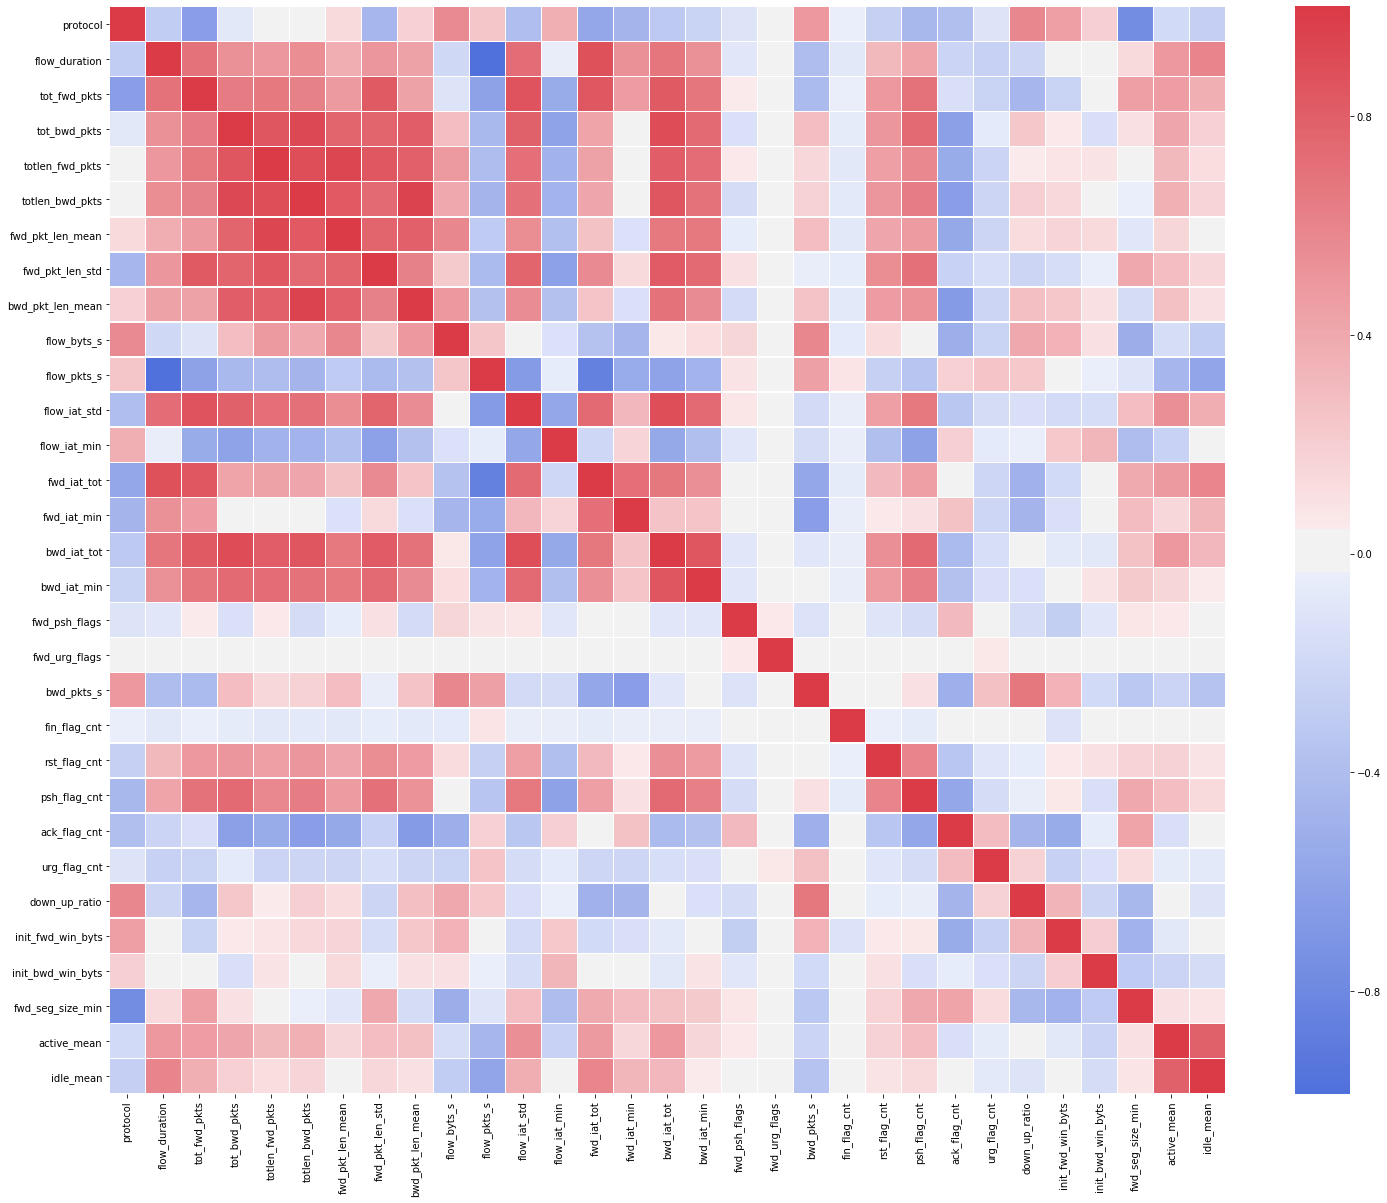

In [11]:
corr_updated = spearmanr(X).correlation
plt.figure(figsize=(25, 20))
sns.heatmap(corr_updated, xticklabels=X.columns, yticklabels=X.columns, linewidths=.5, cmap=sns.diverging_palette(620, 10, as_cmap=True))

## 3. Подготовка модели к обучению

### 3.1. Разделение на тренировку / тест

Для обучения и оценки различных моделей создается раздел «обучение / оценка / тест» с соотношениями `0.8/0.1/0.1`.  
Разделение стратифицируется с использованием категории атаки, чтобы гарантировать, что все атаки представлены в обучающем и тестовом наборе на основе их появления в наборе данных.  

In [20]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

### 3.2 Metrics

In [18]:
percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    10787766
1     2198588
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.8307


Для каждого классификатора будет рассчитана оценка «Средняя оценка точности».

## 4. Классификаторы

### 4.1 Базовый классификатор

Чтобы установить базовый уровень для всех классификаторов, создается `DummyClassifier`, выбирающий класс с наиболее частыми встречами, чтобы делать прогнозы. В этом случае все образцы классифицируются как «0 - доброкачественные», поскольку это основной класс набора данных.  
Этот классификатор показывает, что «~ 83%» всех обучающих примеров относятся к классу «0 - доброкачественный».

In [19]:
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train, y_train.label_is_attack)

print_report('Train', cls_dummy, X_train, y_train.label_is_attack, cls_dummy.predict(X_train))
print_report('Eval', cls_dummy, X_eval, y_eval.label_is_attack, cls_dummy.predict(X_eval))

Classification Report (Train):


/home/glados/anaconda3/envs/ml-ids/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.83      1.00      0.91  10787766
           1       0.00      0.00      0.00   2198588

    accuracy                           0.83  12986354
   macro avg       0.42      0.50      0.45  12986354
weighted avg       0.69      0.83      0.75  12986354

Avg Precision Score: 0.16929986661383173


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91   1348471
           1       0.00      0.00      0.00    274823

    accuracy                           0.83   1623294
   macro avg       0.42      0.50      0.45   1623294
weighted avg       0.69      0.83      0.75   1623294

Avg Precision Score: 0.16929958467166145




### 4.2 Логистическая регрессия

Используя оценку логистической регрессии, линейная модель будет подогнана к данным с использованием реализации [`LogisticRegression`] (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из [scikit -learn] (https://scikit-learn.org/). Чтобы использовать логистическую регрессию, переменные-предикторы масштабируются с помощью [`StandardScaler`] (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).  
При использовании логистической регрессии взвешенный отзыв 0,88 и точность 0,87 лучше, чем базовый уровень, но недостаточны для использования в реальном мире.

In [20]:
scaler = StandardScaler()
scaler.fit(X_train_oh)

StandardScaler(copy=True, with_mean=True, with_std=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


max_iter reached after 1383 seconds


/home/glados/anaconda3/envs/ml-ids/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 23.0min finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93  10787766
           1       0.68      0.49      0.57   2198588

    accuracy                           0.88  12986354
   macro avg       0.79      0.72      0.75  12986354
weighted avg       0.87      0.88      0.87  12986354

Avg Precision Score: 0.42270786673763255


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93   1348471
           1       0.68      0.49      0.57    274823

    accuracy                           0.88   1623294
   macro avg       0.79      0.72      0.75   1623294
weighted avg       0.86      0.88      0.87   1623294

Avg Precision Score: 0.4220228570050777


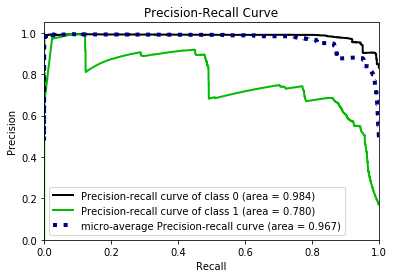

In [21]:
cls_lr = LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
cls_lr.fit(scaler.transform(X_train_oh), y_train.label_is_attack)

print_report('Train', cls_lr, scaler.transform(X_train_oh), y_train.label_is_attack, cls_lr.predict(scaler.transform(X_train_oh)))
print_report('Eval', cls_lr, scaler.transform(X_eval_oh), y_eval.label_is_attack, cls_lr.predict(scaler.transform(X_eval_oh)), plot_pr=True)

### 4.3 Случайный лес (Random Forest)

Следующим оцениваемым алгоритмом является реализация [`RandomForestClassifier`] (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) из [scikit-learn] (https: // scikit- learn.org/). Значения по умолчанию используются для обучения оценщика.  
`RandomForestClassifier` очень хорошо работает с отзывом «0,99» и точностью «0,99».

/home/glados/anaconda3/envs/ml-ids/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.6min remaining:   42.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    5.9s remaining:   23.4s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    7.1s finished


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99  10787766
           1       0.97      0.98      0.97   2198588

    accuracy                           0.99  12986354
   macro avg       0.98      0.98      0.98  12986354
weighted avg       0.99      0.99      0.99  12986354

Avg Precision Score: 0.9502138122792624




[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.7s remaining:    2.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.0s finished


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.96      0.95      0.96    274823

    accuracy                           0.99   1623294
   macro avg       0.98      0.97      0.97   1623294
weighted avg       0.99      0.99      0.99   1623294

Avg Precision Score: 0.9253892970122982


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.7s remaining:    2.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    1.1s finished


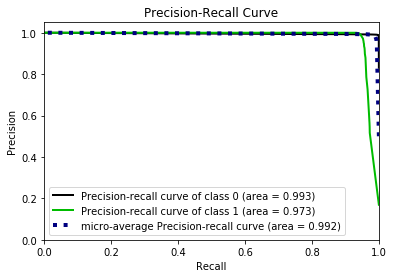

In [23]:
cls_forest = RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
cls_forest.fit(X_train_oh, y_train.label_is_attack)

print_report('Train', cls_forest, X_train_oh, y_train.label_is_attack, cls_forest.predict(X_train_oh))
print_report('Eval', cls_forest, X_eval_oh, y_eval.label_is_attack, cls_forest.predict(X_eval_oh), plot_pr=True)

### 4.4 Повышение градиента (Gradient Boosting)

Последний алгоритм, который нужно оценить, - это Gradient Boosting с помощью библиотеки [CatBoost] (https://catboost.ai/). Поиск по сетке с использованием перекрестной проверки по вариациям гиперпараметров выполняется для определения оптимальных параметров. 

In [9]:
train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
test_pool = Pool(X_test, cat_features=['protocol'])

In [ ]:
minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
cls_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

cls_cb.fit(train_pool, eval_set=eval_pool)

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  10787766
           1       0.97      0.96      0.96   2198588

    accuracy                           0.99  12986354
   macro avg       0.98      0.98      0.98  12986354
weighted avg       0.99      0.99      0.99  12986354

Avg Precision Score: 0.9341507909896061


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.96      0.96    274823

    accuracy                           0.99   1623294
   macro avg       0.98      0.97      0.98   1623294
weighted avg       0.99      0.99      0.99   1623294

Avg Precision Score: 0.9333906081606897


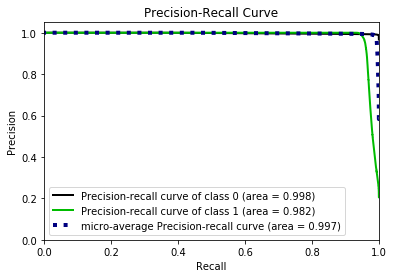

In [11]:
print_report('Train', cls_cb, train_pool, y_train.label_is_attack, cls_cb.predict(train_pool))
print_report('Eval', cls_cb, eval_pool, y_eval.label_is_attack, cls_cb.predict(eval_pool), plot_pr=True)

### 4.5 Выбор модели

При сравнении моделей получены следующие результаты:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|

Gradient Boost показал лучшие результаты из всех моделей и будет использоваться в качестве окончательной оценки.

In [12]:
estimator = cls_cb

### 4.6 Производительность на тестовом наборе данных

Чтобы предсказать реальную производительность, окончательная оценка оценивается на тестовом наборе данных.

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1348471
           1       0.97      0.96      0.96    274824

    accuracy                           0.99   1623295
   macro avg       0.98      0.97      0.98   1623295
weighted avg       0.99      0.99      0.99   1623295

Avg Precision Score: 0.933930661288721


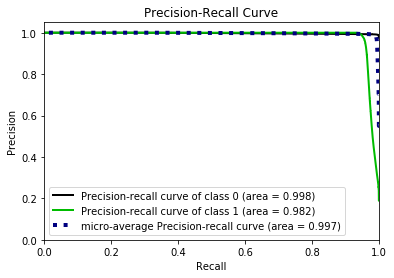

In [13]:
print_report('Test', estimator, test_pool, y_test.label_is_attack, estimator.predict(test_pool), plot_pr=True)

Окончательная оценка показывает очень хорошую производительность с запоминанием «0,99» и точностью «0,99».  
В следующем листинге показаны неправильные классификации в тестовом наборе данных, которые демонстрируют, что атаки типа «Infiltration» часто ошибочно классифицируются.  
Более того, второстепенные классы атак часто ошибочно классифицируются. Передискретизация синтетического меньшинства может быть применена к набору данных поезда для этих классов, чтобы получить лучшую производительность.

In [54]:
def calculate_misclassifiations(y, predictions):
    classifications = y.copy()
    classifications['pred'] = predictions
    counts = classifications.label.value_counts()
    
    misclassifications = classifications[classifications.label_is_attack != classifications.pred]
    mc = pd.DataFrame(misclassifications.label.value_counts())
    mc['percentage'] = mc.apply(lambda x: x[0] / counts[x.name], axis=1)
    mc = mc.sort_values('percentage', ascending=False)
    
    print('Misclassifications:')
    display(mc)

In [55]:
calculate_misclassifiations(y_test, estimator.predict(test_pool))

Misclassifications:


,label,percentage
Infilteration,11937,0.737125
Brute Force -Web,32,0.524590
SQL Injection,3,0.375000
Brute Force -XSS,3,0.130435
DoS attacks-Slowloris,13,0.011829
Benign,8425,0.006248
Bot,35,0.001223
DDoS attacks-LOIC-HTTP,8,0.000139


## 5. Новые данные из различных сетевых сред

Чтобы убедиться, что оценщик имеет одинаково хорошую производительность, как показано в тестовом наборе данных, были проведены дополнительные тесты [CIC-IDS-2017] (https://www.unb.ca/cic/datasets/ids-2017. html), который содержит те же сценарии атак, но записан в другой сетевой среде.

### 5.1. Тест новых данных

In [5]:
novel_base_path= r'/home/glados/Development/Projects/ids-2017/processed'

In [57]:
novel_files = glob.glob(os.path.join(novel_base_path, '*.csv'))

df_novel = load_dataset(novel_files, types, cols=selected_features + ['label'])

X_novel = df_novel.drop(columns=['label', 'label_cat', 'label_is_attack'])
y_novel = df_novel[['label_is_attack', 'label_cat', 'label']]

In [58]:
print(f"Number of test samples: {len(X_novel)}")

Number of test samples: 2830743


Classification Report (Novel):
              precision    recall  f1-score   support

           0       0.84      0.96      0.90   2273097
           1       0.63      0.26      0.36    557646

    accuracy                           0.82   2830743
   macro avg       0.73      0.61      0.63   2830743
weighted avg       0.80      0.82      0.79   2830743

Avg Precision Score: 0.307365267074596


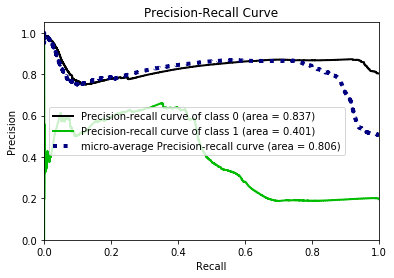

In [59]:
novel_pool = Pool(X_novel, cat_features=['protocol'])

print_report('Novel', estimator, novel_pool, y_novel.label_is_attack, estimator.predict(novel_pool), plot_pr=True)

К сожалению, оценщик имеет очень низкую производительность с данными, записанными в другой сетевой среде, показывающий отзыв «0,82» и точность «0,80». Более того, у оценщика есть только напоминание об атаке, равное 0,26, что недостаточно для реального использования.  
Этот результат предполагает, что данные из одной сетевой среды плохо переносятся на другую сетевую среду.

In [60]:
calculate_misclassifiations(y_novel, estimator.predict(novel_pool))

Misclassifications:


,label,percentage
Bot,1966,1.000000
Infilteration,36,1.000000
Heartbleed,11,1.000000
DDOS LOIT,127927,0.999219
SSH-Bruteforce,5878,0.996778
Brute Force -XSS,638,0.978528
Brute Force -Web,1435,0.952223
SQL Injection,18,0.857143
DoS attacks-SlowHTTPTest,4670,0.849245
DoS attacks-Hulk,180659,0.781827


### 5.2. Важность функции

Для анализа проблемы рассчитываются значения характеристик модели. Наиболее важные функции будут использоваться для сравнения данных из двух наборов данных.

In [44]:
perm = PermutationImportance(estimator, scoring='recall_weighted', n_iter=3).fit(X_test, y_test.label_is_attack)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0575 ± 0.0001,init_fwd_win_byts
0.0274 ± 0.0002,fwd_seg_size_min
0.0131 ± 0.0001,tot_fwd_pkts
0.0114 ± 0.0001,fwd_iat_tot
0.0099 ± 0.0000,totlen_fwd_pkts
0.0046 ± 0.0001,tot_bwd_pkts
0.0046 ± 0.0002,init_bwd_win_byts
0.0032 ± 0.0001,flow_duration
0.0027 ± 0.0001,bwd_pkt_len_mean
0.0026 ± 0.0000,flow_iat_min


In [46]:
features_to_analyze = ['init_fwd_win_byts', 'fwd_seg_size_min', 'tot_fwd_pkts', 'fwd_iat_tot']

Графики и статистика Колмогорова-Смирнова предполагают, что все признаки происходят из разного распределения в обоих наборах данных, что создает проблему для нашего оценщика, поскольку оценщик предполагает, что обучающие, тестовые и реальные данные происходят из одного и того же распределения.

### 5.3. Статистический анализ

В следующих списках сравниваются данные из обоих наборов данных для выявленных функций.  
Полные, безопасные данные и данные об атаках двух наборов данных сравниваются путем построения графика их распределения, вычисления сводной статистики и выполнения [статистики Колмогорова-Смирнова] (https://docs.scipy.org/doc/scipy/reference/generated/scipy .stats.ks_2samp.html).

In [47]:
def stats(vals):
    d = describe(vals)
    return pd.DataFrame.from_dict({
        'nobs': d.nobs, 
        'min': d.minmax[0], 
        'max': d.minmax[1], 
        'mean': d.mean, 
        'median': np.median(vals),
        'std': np.std(vals),
        'variance': d.variance,
        'skewness': d.skewness, 
        'kurtosis': d.kurtosis
     }, orient='index')


def print_distributions(X_1, y_1, X_2, y_2, f, label_1='1', label_2='2'):
    print(f"Distribution for field '{f}'")
    print("===================================")
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 20))
    
    X_f_1 = X_1[f]
    X_f_2 = X_2[f]
    X_attack_1 = X_f_1[y_1.label_is_attack == 1]
    X_benign_1 = X_f_1[y_1.label_is_attack == 0]
    X_attack_2 = X_f_2[y_2.label_is_attack == 1]
    X_benign_2 = X_f_2[y_2.label_is_attack == 0]

    sns.distplot(X_f_1, label=f'All {label_1}', hist=False, ax=ax1)
    sns.distplot(X_f_2, label=f'All {label_2}', hist=False, ax=ax1)

    sns.distplot(X_benign_1, label=f'Benign {label_1}', hist=False, ax=ax2)
    sns.distplot(X_benign_2, label=f'Benign {label_2}', hist=False,  ax=ax2)

    sns.distplot(X_attack_1, label=f'Attack {label_1}', hist=False, ax=ax3)
    sns.distplot(X_attack_2, label=f'Attack {label_2}', hist=False, ax=ax3)    
    plt.show()

    print('K2 All:')
    print(ks_2samp(X_f_1, X_f_2))
    print('K2 Benign:')
    print(ks_2samp(X_benign_1, X_benign_2))
    print('K2 Attack:')
    print(ks_2samp(X_attack_1, X_attack_2))

    st = pd.concat({
        f'All {label_1}': stats(X_f_1),
        f'All {label_2}': stats(X_f_2),
        f'Benign {label_1}': stats(X_benign_1),
        f'Benign {label_2}': stats(X_benign_2),
        f'Attack {label_1}': stats(X_attack_1),
        f'Attack {label_2}': stats(X_attack_2)
    }, axis=1)
    
    print()
    print(st)
    print('\n')

### 5.5. Статистические тесты

Чтобы исключить, что оценщик использует функции, которые актуальны только для обучающего набора данных и не актуальны для нового набора данных, на следующем шаге выполняется [статистика Колмогорова-Смирнова] (https://docs.scipy.org/doc/scipy/reference /generated/scipy.stats.ks_2samp.html) по всем функциям наборов данных.

In [ ]:
from scipy.stats import ks_2samp

def ks2(x1, x2, f):
    return ks_2samp(x1[f], x2[f]).pvalue


df = load_dataset(csv_files, types)
X_2018 = df.drop(columns=['label', 'label_cat', 'label_is_attack', 'timestamp'])
y_2018 = df[['label_is_attack', 'label_cat', 'label']]

df_2017 = load_dataset(novel_files, types)
X_2017 = df_2017.drop(columns=['label', 'label_cat', 'label_is_attack', 'timestamp'])
y_2017 = df_2017[['label_is_attack', 'label_cat', 'label']]

X_2018_attack = X_2018[(y.label_is_attack == 1)]
X_2018_benign = X_2018[(y.label_is_attack == 0)]

X_2017_attack = X_2017[(y_2017.label_is_attack == 1)]
X_2017_benign = X_2017[(y_2017.label_is_attack == 0)]

k2_results = []

for c in X_2018.columns:   
    print(f"Processing {c}...")
    r = pd.DataFrame.from_dict(data = { 
        'all': ks2(X_2018, X_2017, c),
        'attack': ks2(X_2018_benign, X_2017_benign, c),
        'benign': ks2(X_2018_attack, X_2017_attack, c)
    }, orient='index', columns=[c])
    k2_results.append(r)
    
k2_values = pd.concat(k2_results, axis=1)

После удаления признака без отклонения осталось только 2 признака, которые происходят из одного и того же распределения в обоих наборах данных `fwd_urg_flags`,` cwe_flag_count`, оба не являются хорошими предикторами.  
Это показывает, что данные из разных сетевых сред распределяются по-разному.

## 6. Модель из объединенных данных

Чтобы создать оценщик, который хорошо обобщает данные из различных сетевых сред, оценщик создается с использованием комбинированного [CIC-IDS-2017] (https://www.unb.ca/cic/datasets/ids-2017.html ) и [CIC-IDS-2018] (https://www.unb.ca/cic/datasets/ids-2018.html).

### 6.1. Загрузка объединённых данных

In [6]:
combined_files = glob.glob(os.path.join(dataset_base_path, '*.csv')) + glob.glob(os.path.join(novel_base_path, '*.csv'))

df = load_dataset(combined_files, types, cols=selected_features + ['label'])
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)

### 6.2. Синтетическая передискретизация
Для повышения количества экземпляров этих классов к ` 100000` и повышения уровня обнаружения атак, используется метод `Synthetic Minority Oversampling`

In [8]:
y_train.label.value_counts()

Benign                      12606243
DoS attacks-Hulk              554388
DDOS attack-HOIC              548809
DDoS attacks-LOIC-HTTP        460953
Bot                           230526
FTP-BruteForce                161038
SSH-Bruteforce                154789
Infilteration                 129576
PortScan                      127144
DoS attacks-SlowHTTPTest      116311
DDOS LOIT                     102422
DoS attacks-GoldenEye          41441
DoS attacks-Slowloris          13429
Brute Force -Web                1694
DDOS attack-LOIC-UDP            1384
Brute Force -XSS                 706
SQL Injection                     86
Heartbleed                         9
Name: label, dtype: int64

In [9]:
cnts = y_train.label_cat.value_counts()
sample_dict = {}

for i in np.unique(y_train.label_cat):
    sample_dict[i] = max(cnts[i], 100000)

In [11]:
sm = SMOTENC(sampling_strategy=sample_dict, categorical_features=[0], n_jobs=24)
X_train_s, y_train_s = sm.fit_resample(X_train, y_train.label_cat)

In [12]:
print('Class occurrences:')
Counter(y_train_s)

Class occurrences:


Counter({12: 161038,
         0: 12606243,
         5: 548809,
         9: 554388,
         7: 460953,
         17: 154789,
         11: 100000,
         1: 230526,
         10: 116311,
         4: 102422,
         8: 100000,
         14: 129576,
         15: 127144,
         6: 100000,
         2: 100000,
         3: 100000,
         16: 100000,
         13: 100000})

In [13]:
y_train_s = (y_train_s != 0).astype('int')
print('Binary label occurrences:')
Counter(y_train_s)

Binary label occurrences:


Counter({1: 3285956, 0: 12606243})

### 6.3. Training

Для комбинированного оценщика модель повышения градиента обучается с использованием поиска по сетке, чтобы найти лучший набор гиперпараметров.

In [16]:
def train_catboost_grid(train_pool, y_train):
    minority_class_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print(f"Minority class weight: {minority_class_weight}")
    
    param_grid = {
        'iterations': [500, 1000, 1500],
        'learning_rate': [0.3, 0.03, 0.003],
        'depth': [3, 6, 9],
        'l2_leaf_reg': [3, 6]
    }

    cls = CatBoostClassifier(loss_function='Logloss',
                             eval_metric='Recall',
                             class_weights=[1, minority_class_weight],
                             task_type='GPU',
                             verbose=True)

    cb_results = cls.grid_search(param_grid, train_pool)

    print('\nOptimal Parameters:')
    print(cb_results['params'])
    return cls

In [17]:
train_pool = Pool(X_train_s, y_train_s, cat_features=[0])
test_pool = Pool(X_test.values, cat_features=[0])

In [18]:
comb_estimator = train_catboost_grid(train_pool, y_train_s)

Minority class weight: 3.8364004265425344
0:	loss: 0.9676589	best: 0.9676589 (0)	total: 2m 14s	remaining: 1h 58m 55s
1:	loss: 0.9634058	best: 0.9676589 (0)	total: 4m 18s	remaining: 1h 52m 4s
2:	loss: 0.9516361	best: 0.9676589 (0)	total: 6m 25s	remaining: 1h 49m 16s
3:	loss: 0.9674853	best: 0.9676589 (0)	total: 8m 29s	remaining: 1h 46m 7s
4:	loss: 0.9636844	best: 0.9676589 (0)	total: 10m 33s	remaining: 1h 43m 30s
5:	loss: 0.9516361	best: 0.9676589 (0)	total: 12m 41s	remaining: 1h 41m 28s
6:	loss: 0.9687036	best: 0.9687036 (6)	total: 16m 39s	remaining: 1h 51m 53s
7:	loss: 0.9658026	best: 0.9687036 (6)	total: 20m 39s	remaining: 1h 58m 47s
8:	loss: 0.9516102	best: 0.9687036 (6)	total: 24m 41s	remaining: 2h 3m 28s
9:	loss: 0.9685558	best: 0.9687036 (6)	total: 28m 40s	remaining: 2h 6m 9s
10:	loss: 0.9656976	best: 0.9687036 (6)	total: 32m 40s	remaining: 2h 7m 43s
11:	loss: 0.9516361	best: 0.9687036 (6)	total: 36m 42s	remaining: 2h 8m 29s
12:	loss: 0.9689914	best: 0.9689914 (12)	total: 42m 32s

При проведении сеточного поиска были определены следующие параметры оптимальной оценки:

|Parameter|Value|
|---------|-----|
|Depth|9|
|L2 Leaf Regularization|3|
|Iterations|1000|
|Learning Rate|0.3|

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99  12606243
           1       0.98      0.97      0.97   3285956

    accuracy                           0.99  15892199
   macro avg       0.99      0.98      0.98  15892199
weighted avg       0.99      0.99      0.99  15892199

Avg Precision Score: 0.955579742683623


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   3151562
           1       0.97      0.96      0.97    661176

    accuracy                           0.99   3812738
   macro avg       0.98      0.98      0.98   3812738
weighted avg       0.99      0.99      0.99   3812738

Avg Precision Score: 0.9425657531936107


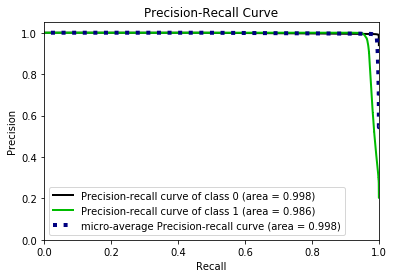

In [21]:
print_report('Train', comb_estimator, train_pool, y_train_s, comb_estimator.predict(train_pool))
print_report('Test', comb_estimator, test_pool, y_test.label_is_attack, comb_estimator.predict(test_pool), plot_pr=True)

Комбинированный оценщик показывает многообещающую производительность на тестовом наборе данных с высокой полнотой «0,99», точностью «0,99» и уровнем обнаружения атак (класс отзыва 1) «0,96».

In [22]:
comb_estimator.save_model('models/gradient_boost_model')

## 7. Выводы

В ходе проделанной работы было выяснено, что нейронная сеть в таком виде оказалась работоспособной и выдаёт устраивающий нас результат. Однако, следует отметить, что данная система в дальнейшем будет совершенствоваться для приобретения более продвинутых умений и улучшения качества определения возможной угрозы.